In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector

db =  mysql.connector.connect(host = "localhost",
                             username = "root",
                             password = "12345678",
                             database = "data_analysis")

cur = db.cursor()

# BASIC QUERIES:

1. List all unique cities where customers are located.


In [2]:
query = """ select distinct customer_city from customers """

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns =['city'])
df.head()

,city
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


2. Count the number of orders placed in 2017.

In [3]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp)=2017 """

cur.execute(query)
data = cur.fetchall()

"number of orders placed per year",data[0][0]

('number of orders placed per year', 45101)

3. Find the total sales per category.

In [4]:
query = """ select upper(products.product_category) category,
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id= order_items.order_id
group by category
"""

cur.execute(query)
data = cur.fetchall()

df= pd.DataFrame(data, columns= ['product','sales'])
"total sales per category" ,df.head()

('total sales per category',
                 product       sales
 0             PERFUMERY   506738.66
 1  FURNITURE DECORATION  1430176.39
 2             TELEPHONY   486882.05
 3        BED TABLE BATH  1712553.67
 4            AUTOMOTIVE   852294.33)

4. Calculate the percentage of orders that were paid in installments.

In [5]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100
from payments
"""

cur.execute(query)
data = cur.fetchall()

"the percentage of orders that were paid in installments",data[0][0]

('the percentage of orders that were paid in installments', Decimal('99.9981'))

5. Count the number of customers from each state.

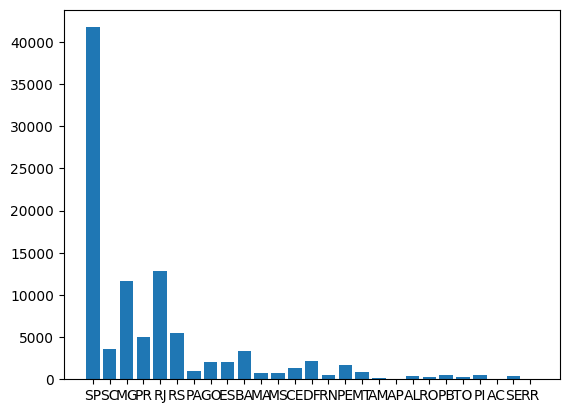

In [6]:
query = """ select customer_state, count(customer_id) from customers group by
customer_state
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data,columns = ['state','total customers'])
# df.head()

plt.bar(df['state'], df['total customers'])  
plt.show()

# INTERMEDIATE QUERIES:

1. Calculate the number of orders per month in 2018.

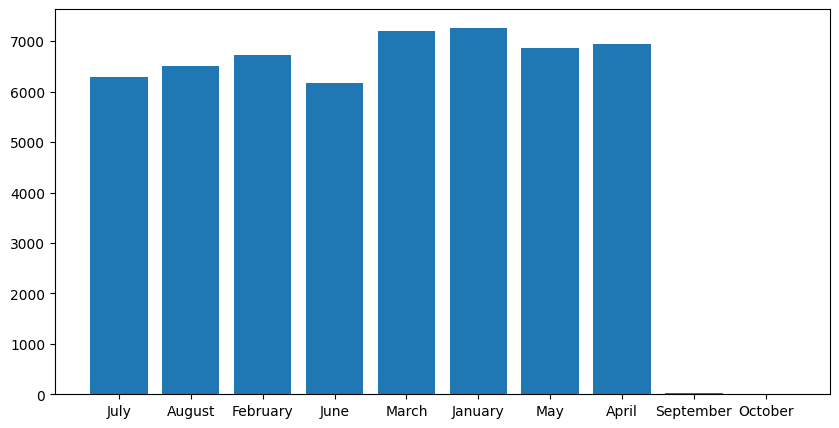

In [7]:
query = """ select monthname(order_purchase_timestamp) months, count(order_id) from orders where year(order_purchase_timestamp)= 2018
group by months"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['month','total_orders'])
# df

plt.figure(figsize= (10,5))
plt.bar(df['month'], df['total_orders'])
plt.show()

2. Find the average number of products per order, grouped by customer city.

In [13]:
query = """ with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items 
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)

select customers.customer_city, avg(count_per_order.oc)
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns = ['customer_city','avg_no_of_products'])
df.head()

,customer_city,avg_no_of_products
0,sao paulo,1.1562
1,sao jose dos campos,1.1385
2,porto alegre,1.1749
3,indaial,1.1154
4,treze tilias,1.2727


 3. Calculate the percentage of total revenue contributed by each product category.

In [19]:
query = """ select upper(products.product_category) category,
round((sum(payments.payment_value)/ (select sum(payment_value) from payments))*100,2) sales
from products join order_items 
on products.product_id = order_items.product_id
join payments 
on payments.order_id= order_items.order_id
group by category order by sales desc
"""

cur.execute(query)
data = cur.fetchall()

df = pd.DataFrame(data, columns= ['products','revenue_percetage'])
df.head()
 

,products,revenue_percetage
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93


4. Identify the correlation between product price and the number of times a product has been purchased.

In [28]:
query = """ select products.product_category,
count(order_items.product_id),
avg(order_items.product_id)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category
"""
 
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns= ['Product','order_count','avg_price'])
df.head()


,Product,order_count,avg_price
0,HEALTH BEAUTY,9670,0.0
1,sport leisure,8641,0.0
2,Cool Stuff,3796,0.0
3,computer accessories,7827,0.0
4,Watches present,5991,0.0


5. Calculate the total revenue generated by each seller, and rank them by revenue.


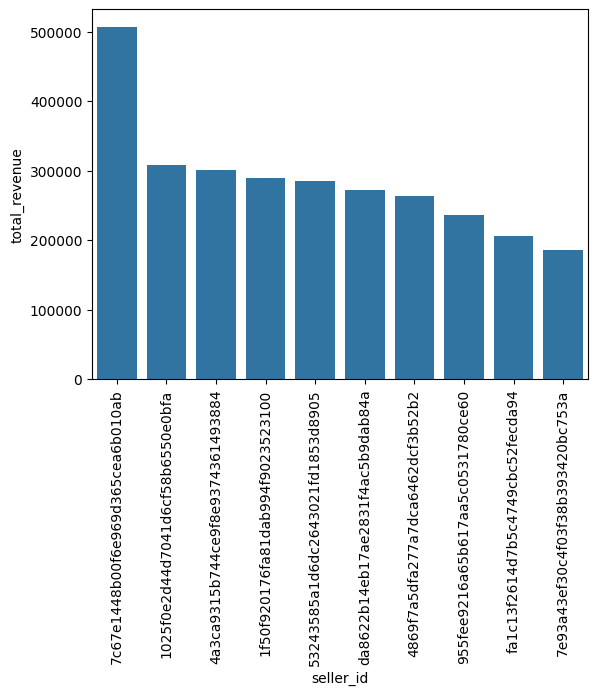

In [35]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from 
( select order_items.seller_id, sum(payments.payment_value)
revenue from order_items join payments 
on order_items.order_id = payments.order_id 
group by order_items.seller_id) as a
"""
 
cur.execute(query)
data = cur.fetchall()
data

df = pd.DataFrame(data, columns= ['seller_id','total_revenue','ranks'])
df.head()

sns.barplot(x= 'seller_id', y= 'total_revenue', data = df.head(10))
plt.xticks(rotation = 90)
plt.show()